# Predicting Temperatures using Recurrent Neural Networks


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch07_RNN/ec07_1_rnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
You need also to copy the "jena_climate_2009_2016.csv" file from the
<a href="https://github.com/DeepTrackAI/DeepLearningCrashCourse/tree/main/Ch07_RNN/ec07_1_rnn">notebook folder</a> in GitHub to the Colab/Kaggle work directory.
</div>

In [28]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that uses different kinds of recurrent neural networks to predict the temperature in the Jena Climate Dataset.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 7-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Understanding Recurrent Relations

Implement a comb filter ...

In [1]:
input_series = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

hidden_state, U, V = 0, 0.5, 0.5

output_series = []
for input_data in input_series:
    hidden_state = U * input_data + V * hidden_state
    output_data = hidden_state
    output_series.append(output_data)

print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

Output Series: ['0.00', '0.00', '0.00', '0.00', '0.50', '0.75', '0.88', '0.94', '0.97', '0.98', '0.99', '1.00', '0.50', '0.25', '0.12', '0.06', '0.03', '0.02', '0.01', '0.00']


... and transform it into a simple recurrent neural network (which generates some meaningless output because of the random initialization of its weights).

In [2]:
import numpy as np

def sigmoid(x):
    """Simple implementation of sigmoid function."""
    return 1 / (1 + np.exp(-x))

input_series = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

hidden_state = 0
U, V, W, b = np.random.normal(size=4)

output_series = []
for input_data in input_series:
    hidden_state = sigmoid(U * input_data + V * hidden_state + b)
    output_data = sigmoid(W * hidden_state)
    output_series.append(output_data)

print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

Output Series: ['0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51']


## Downloading the Jena Climate Dataset

This dataset contains timeseries recorded at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany. It’s made up of 14 different quantities recorded every 10 minutes over several years, from January 1st 2009 to December 31st 2016.

Load the Jena Climante Dataset ...

In [3]:
import pandas as pd

dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

... and display its header and first few elements.

In [4]:
print(dataframe.head())

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00          3.33          3.11          0.22       1.94   
01.01.2009 00:20:00          3.23          3.02          0.21       1.89   
01.01.2009 00:30:00          3.21          3.01          0.20       1.88   
01.01.2009 00:40:00          3.26          3.07          0.19       1.92   
01.01.2009 00:50:00      

### Visualizing the Data

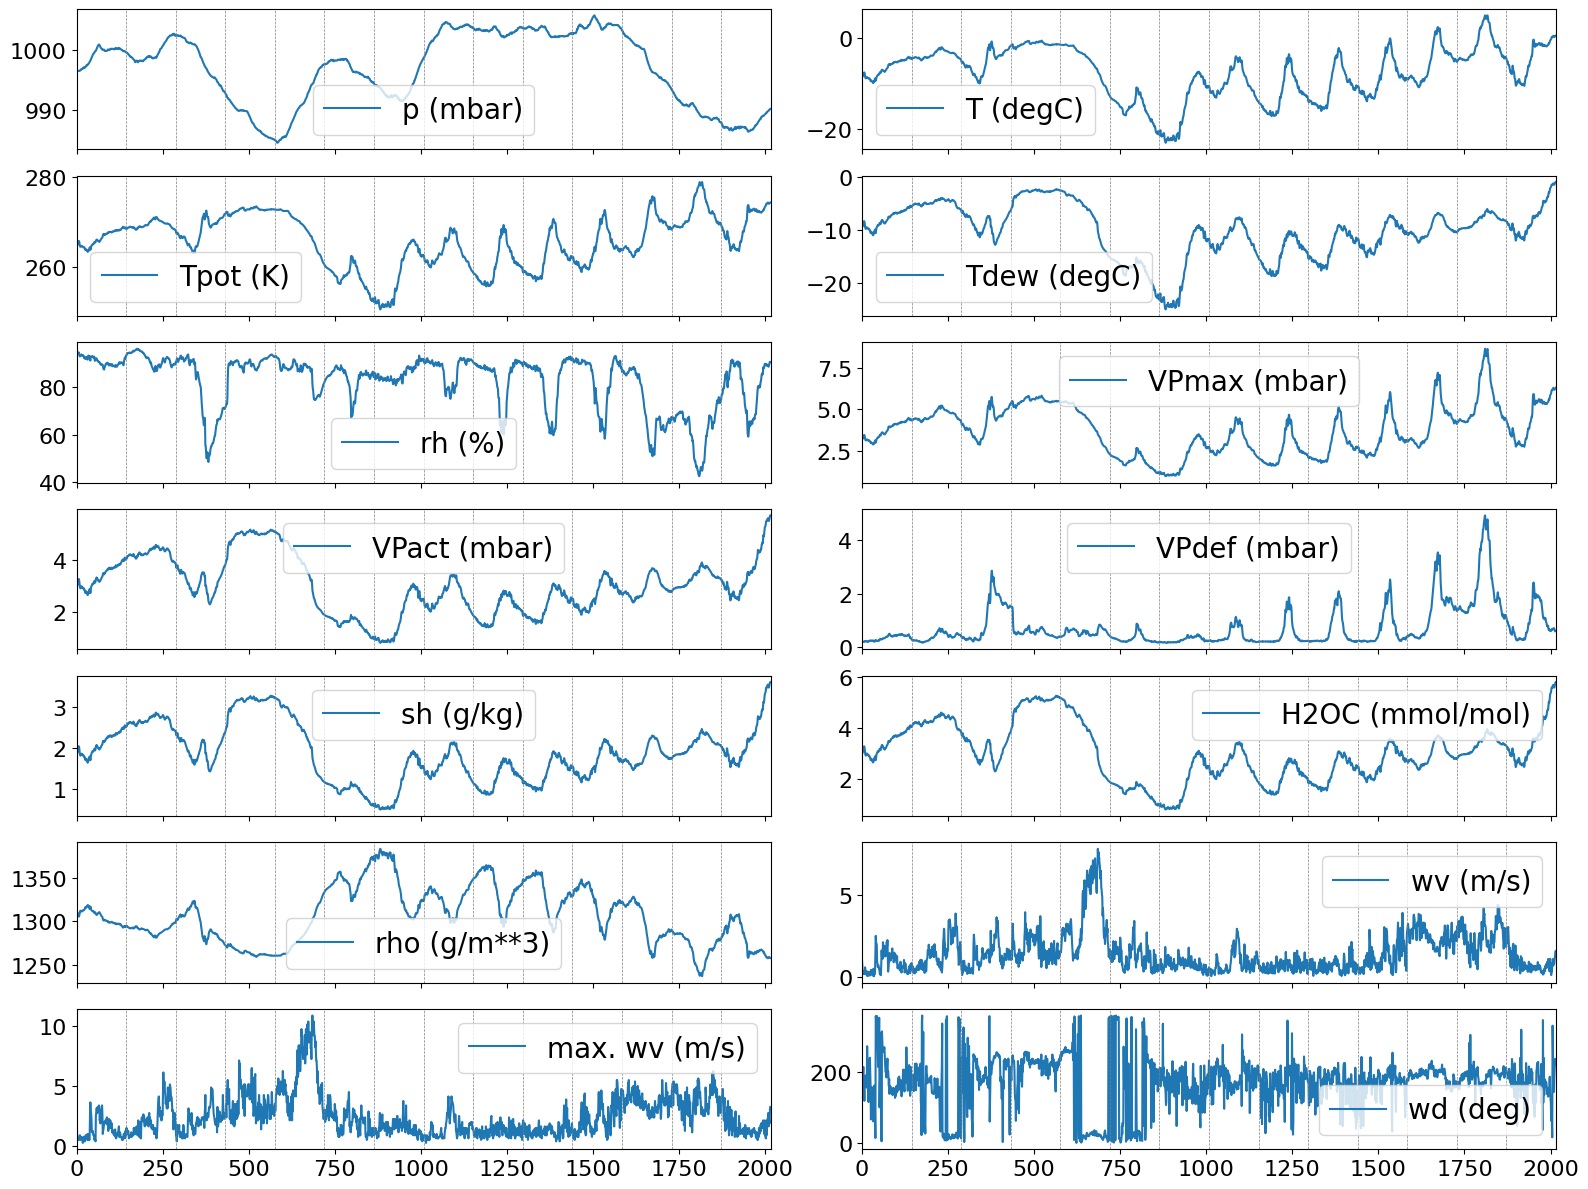

In [5]:
import matplotlib.pyplot as plt
import numpy as np

start, days, daily_samples = 0, 14, 144
end = start + daily_samples * days

fig, axs = plt.subplots(7, 2, figsize=(16, 12), sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(np.arange(start, end), data[start:end, i], label=header[i])
    ax.set_xlim(start, end)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=20)

    for day in range(1, days):
        ax.axvline(x=start + daily_samples * day,
                   color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

### Preprocessing the Data

Reshape the data in a format ready to train a recurrent neural network ...

In [6]:
n_samples, n_features = data.shape[0], data.shape[1]
past_seq = 2 * daily_samples
lag = 72
temp_idx = 1  # Temperature (Celsius) index.

in_sequences, targets = [], []
for i in range(past_seq, n_samples - lag, daily_samples):
    in_sequences.append(data[i - past_seq:i, :])
    targets.append(data[i + lag:i + lag + 1, temp_idx])
in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)

... check the input shape ...

In [7]:
print(in_sequences.shape)

(2918, 288, 14)


... check the output shape ...

In [8]:
print(targets.shape)

(2918, 1)


... split the data ...

In [9]:
import deeptrack as dt

sources = dt.sources.Source(inputs=in_sequences, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

... normalize the data ...

In [10]:
import torch

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx]) 
                    / train_std[temp_idx])

... and define the data loaders.

In [11]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                 inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Implementing a Common-Sense Benchmark

Define a common-sense benchmark stating tha temperature the next day is the same as that the previous day at the same time ...

In [12]:
temperature = data[:, temp_idx]
benchmark_celsius = np.mean(
    np.abs(
        temperature[daily_samples + lag::daily_samples]
        - temperature[lag:-(daily_samples - lag):daily_samples]
    )
)
benchmark = benchmark_celsius / train_std[temp_idx]

... print the benchark value in degrees Celsius ...

In [13]:
print(f"Benchmark Celsius: {benchmark_celsius}")

Benchmark Celsius: 2.664549503254539


... and in normalized units.

In [14]:
print(f"Normalized Benchmark: {benchmark}")

Normalized Benchmark: 0.3145232714646806


## Determining on Which Device to Perform the Computations

Implement a function to determine the device to be used to perform the computations ...

In [ ]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

... use to select the device ...

In [16]:
device = get_device()

... and print the selected device.

In [17]:
print(device)

cpu


## Implementing a Simple Recurrent Neural Network

Define a recurrent neural network in PyTorch ...

In [18]:
import torch.nn as nn

rnn = nn.RNN(input_size=in_sequences.shape[2], hidden_size=2, batch_first=True)
fc = nn.Linear(in_features=2, out_features=1)
rnn.to(device); fc.to(device);

... train and validate it ...

In [19]:
criterion = nn.L1Loss()  # MAE Loss.
parameter_list = list(rnn.parameters()) + list(fc.parameters())
optimizer = torch.optim.Adam(parameter_list, lr=0.001)

epochs = 100
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0.0
    for in_sequences, targets in train_loader:
        optimizer.zero_grad()

        in_sequences, targets = in_sequences.to(device), targets.to(device)
        hidden_sequences, _ = rnn(in_sequences)  # RNN layer.
        last_hidden_states = hidden_sequences[:, -1, :]  # Last hidden states.
        predictions = fc(last_hidden_states)

        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")
    
    val_loss = 0.0
    with torch.no_grad():
        for in_sequences, targets in val_loader:
            in_sequences, targets = in_sequences.to(device), targets.to(device)
            hidden_sequences, _ = rnn(in_sequences)
            last_hidden_states = hidden_sequences[:, -1, :]
            predictions = fc(last_hidden_states)

            loss = criterion(predictions, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

Epoch 0 Training Loss: 0.9087
Epoch 0 Validation Loss: 0.7383
Epoch 1 Training Loss: 0.7523
Epoch 1 Validation Loss: 0.6198
Epoch 2 Training Loss: 0.6444
Epoch 2 Validation Loss: 0.5474
Epoch 3 Training Loss: 0.5707
Epoch 3 Validation Loss: 0.4954
Epoch 4 Training Loss: 0.5184
Epoch 4 Validation Loss: 0.4625
Epoch 5 Training Loss: 0.4843
Epoch 5 Validation Loss: 0.4416
Epoch 6 Training Loss: 0.4647
Epoch 6 Validation Loss: 0.4293
Epoch 7 Training Loss: 0.4515
Epoch 7 Validation Loss: 0.4195
Epoch 8 Training Loss: 0.4407
Epoch 8 Validation Loss: 0.4118
Epoch 9 Training Loss: 0.4311
Epoch 9 Validation Loss: 0.4044
Epoch 10 Training Loss: 0.4228
Epoch 10 Validation Loss: 0.3983
Epoch 11 Training Loss: 0.4159
Epoch 11 Validation Loss: 0.3933
Epoch 12 Training Loss: 0.4105
Epoch 12 Validation Loss: 0.3895
Epoch 13 Training Loss: 0.4056
Epoch 13 Validation Loss: 0.3874
Epoch 14 Training Loss: 0.4029
Epoch 14 Validation Loss: 0.3851
Epoch 15 Training Loss: 0.4004
Epoch 15 Validation Loss: 0.3

... implement a function to plot the training and validation losses ...

In [20]:
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

... and use it to plot the losses.

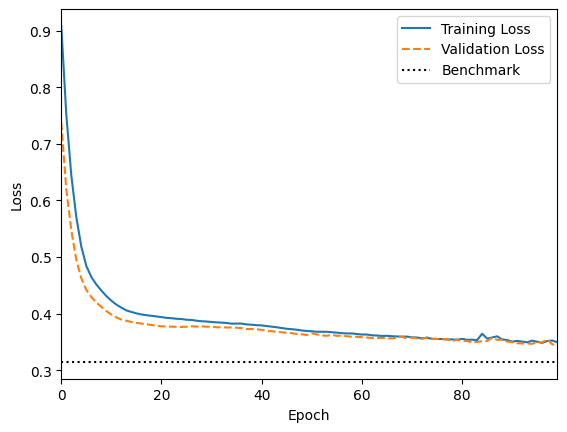

In [21]:
plot_training(epochs, train_losses, val_losses, benchmark)

## Implementing the Recurrent Neural Network in a More Compact Form with Deeplay

Define a recurrent neural network in deeplay ...

In [22]:
import deeplay as dl

rnn_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[2],
    out_features=1,
    rnn_type="RNN",
)
rnn_simple = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.001)).create()

... print out the application architecture ...

In [23]:
print(rnn_simple)

Regressor(
  (loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RecurrentModel(
    (blocks): LayerList(
      (0): Sequence1dBlock(
        (layer): RNN(14, 2, batch_first=True)
      )
    )
    (head): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Linear(in_features=2, out_features=1, bias=True)
          (activation): Identity()
        )
      )
    )
  )
)


... and train it.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_met

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

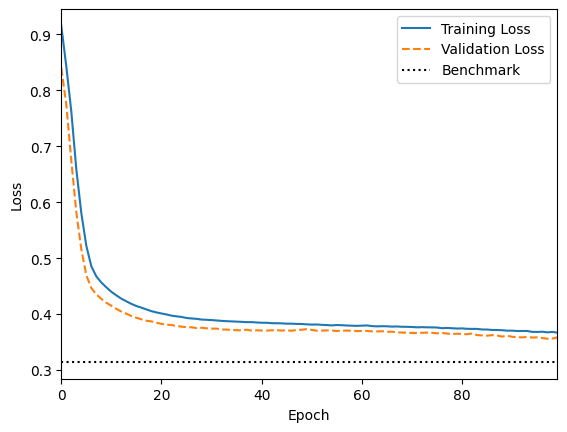

In [ ]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_simple, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Stacking Multiple Recurrent Layers

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 1.6 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

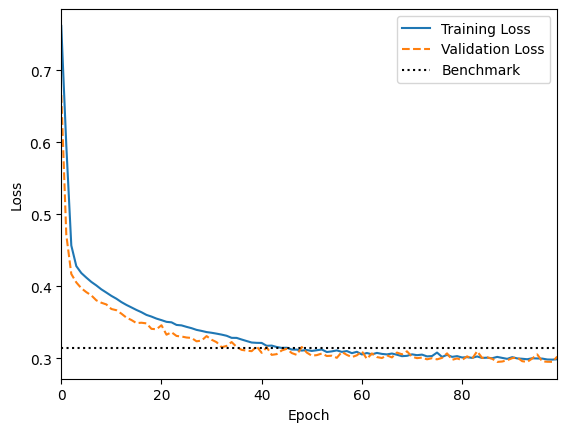

In [ ]:
rnn_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[16, 16, 16],
    out_features=1,
    rnn_type="RNN",
)
rnn_stacked = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.0001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Gated Recurrent Units

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 1.4 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

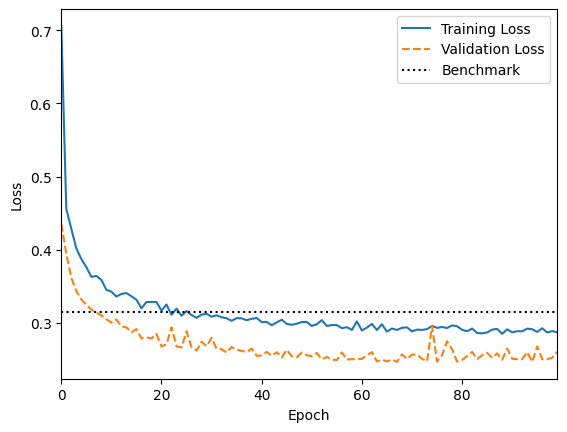

In [ ]:
gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Long Short-Term Memory Networks

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 1.9 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

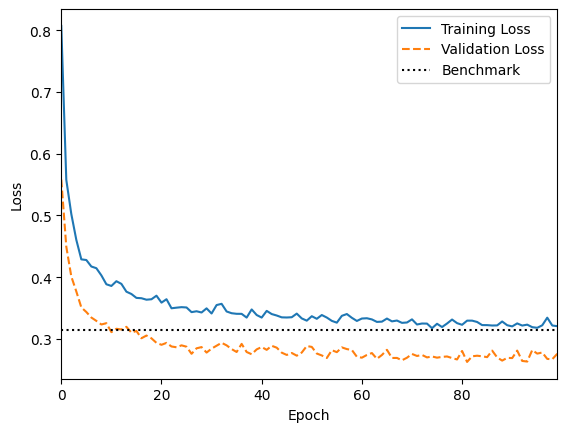

In [ ]:
lstm_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="LSTM",
    dropout=0.3,
)
lstm_stacked = dl.Regressor(lstm_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(lstm_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)